# QBUS3850: Lab 2 Tasks

The data set CBA_1991-2017.csv (dataset could found on Canvas) contains the monthly closing stock prices stock prices of Commonwealth Bank of Australia (CBA) from August 1991 to December 2017.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

## 1. Load the data and plot the original data curve.

              Close
Date               
1991-08-31  6.78690
1991-09-30  7.50763
1991-10-31  7.40753
1991-11-30  7.86800
1991-12-31  7.32745


Text(0.5, 1.0, 'CBA Monthly Prices')

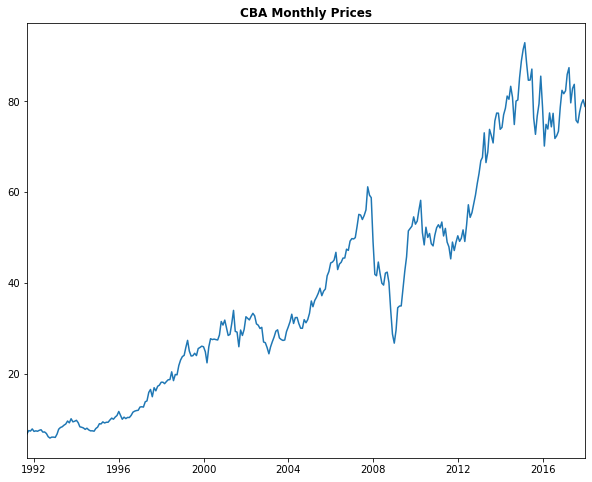

In [3]:
data = pd.read_csv('CBA_1991-2017.csv', parse_dates=['Date'], index_col='Date')
print( data.head() )
fig, axs = plt.subplots(figsize = (10,8))
axs.plot(data)
axs.set_xlim(data.index.min(), data.index.max())
axs.set_title('CBA Monthly Prices', weight = 'bold')

## 2. Write Python script to do a $2 \times 12$-MA (Moving average of moving average) method and plot them. You may call pandas package’s rolling_mean or rolling function to do the $2 \times 12$ smoothing. Then plot the smoothing results onto the original time-series data curve.

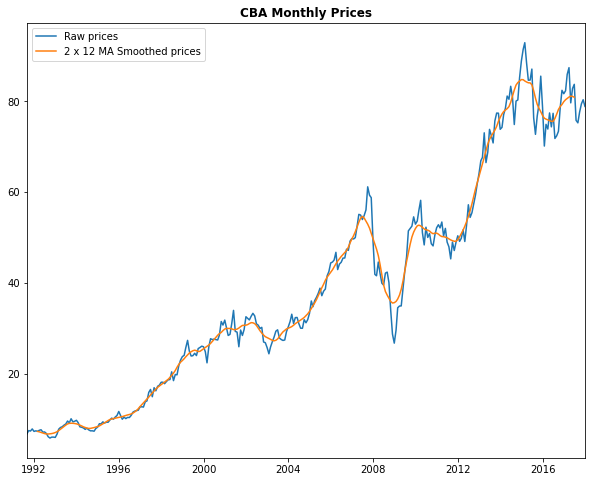

In [5]:
from pandas.api.indexers import FixedForwardWindowIndexer
indexer = FixedForwardWindowIndexer(window_size=2)
Trend1 = data.rolling(indexer).mean().rolling(12,center = True).mean()
fig, axs = plt.subplots(figsize = (10,8))
axs.plot(data, label = 'Raw prices')
axs.plot(Trend1, label = '2 x 12 MA Smoothed prices')
axs.set_xlim(data.index.min(), data.index.max())
axs.set_title('CBA Monthly Prices', weight = 'bold')
axs.legend()

## 3. Do a $5$-MA and compare the results with $2 \times 12$-MA. You may plot these 2 MA results together and examine what is the difference.

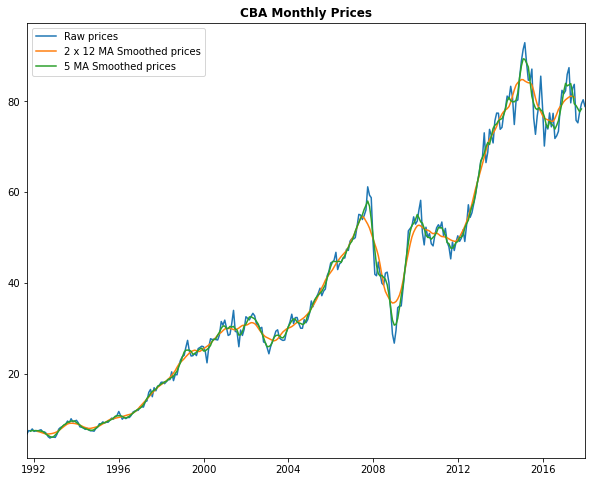

In [6]:
Trend2 = data.rolling(5,center = True).mean()
fig, axs = plt.subplots(figsize = (10,8))
axs.plot(data, label = 'Raw prices')
axs.plot(Trend1, label = '2 x 12 MA Smoothed prices')
axs.plot(Trend2, label = '5 MA Smoothed prices')
axs.set_xlim(data.index.min(), data.index.max())
axs.set_title('CBA Monthly Prices', weight = 'bold')
axs.legend()

### 4. Carry out an additive classical decomposition on the log series

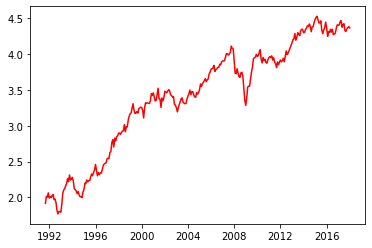

In [7]:
# find the log of the series
ts_log = np.log( data['Close'] )
plt.figure()
plt.plot(ts_log, color='red',label='log')

Test Statistic                -7.686744e+00
p-value                        1.454827e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.910000e+02
Critical Value (1%)           -3.453023e+00
Critical Value (5%)           -2.871524e+00
Critical Value (10%)          -2.572090e+00
dtype: float64


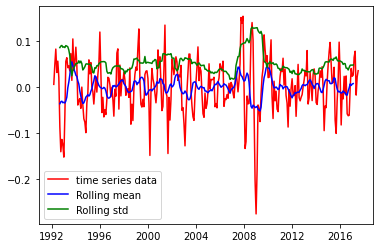

In [8]:
## Construct the trend and residual.
trend = ts_log.rolling( 12, center = True).mean().rolling( 2, center = True ).mean().shift(-1)
ts_res = ts_log - trend
ts_res.dropna(inplace = True)

## Visual check for stationarity
rolling_data_res = pd.Series(ts_res, dtype='float64').rolling(12,center=True)
plt.figure()
plt.plot(ts_res,'r-',label="time series data")
plt.plot(rolling_data_res.mean(),'b-',label="Rolling mean")
plt.plot(rolling_data_res.std(),'g-',label="Rolling std")
plt.legend()

## Dickey-Fuller test for stationarity
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(ts_res, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

In [9]:
## Detrend data
ts_res = ts_log - trend
#print( ts_res[:12] )
#print( ts_res[-12:] )

## Remove incomplete years and reshape array. There are 24 years of complete yearly data.
ts_res_clean = np.nan_to_num( ts_res[17:-12] )
monthly_S = np.reshape( ts_res_clean, (24,12) )

## Each of the 12 columns of monthly_S contains data for a given month.
print( monthly_S[0,:] )
print( monthly_S[23,:] )


[-0.06089803  0.05586706  0.0639705   0.04227937  0.04605686  0.03519668
  0.0730352   0.01461946  0.1049607   0.03632432  0.05601239  0.08695074]
[-0.08258301 -0.01391183 -0.02571706  0.02334532 -0.01501677  0.02426518
 -0.05827762 -0.06247002 -0.06158856 -0.00054298  0.04049937  0.0235755 ]


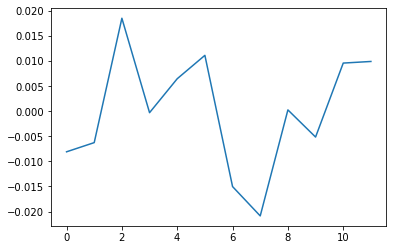

In [10]:
## Compute seasonal indices
monthly_avg = np.mean(monthly_S, axis=0)

## De-mean seasonal indices
mean_allmonth = monthly_avg.mean()
monthly_avg_normalized = monthly_avg - mean_allmonth
plt.plot( monthly_avg_normalized )
assert( np.isclose( monthly_avg_normalized.mean(), 0.0 ) )

<Figure size 432x288 with 0 Axes>

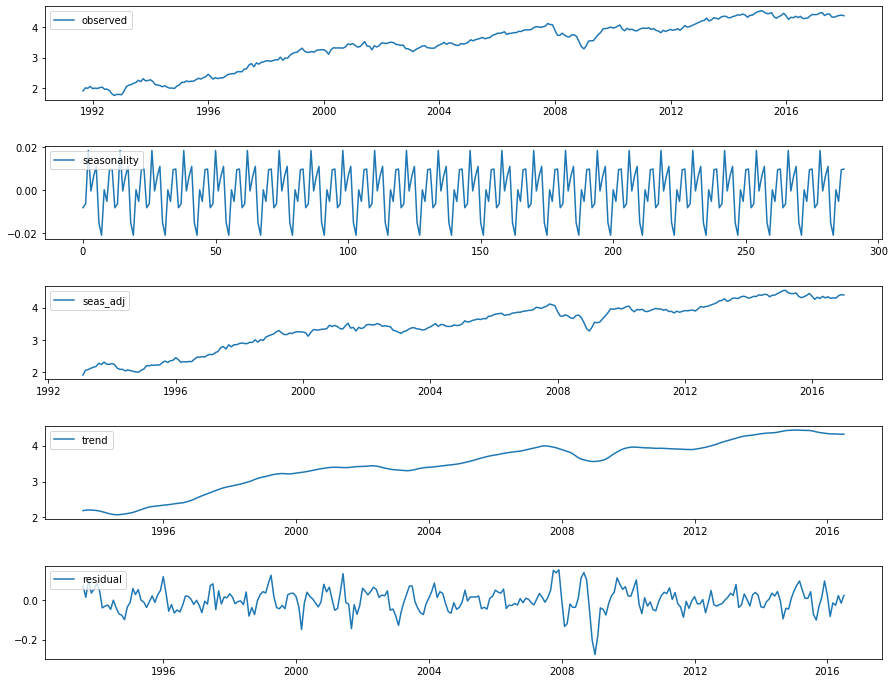

In [11]:
## Repeat the seasonal indices over 24 years
tiled_avg = np.tile(monthly_avg_normalized, 24)

## Seasonally adjusted = original - seasonal indices
seasonally_adjusted = ts_log[17:-12] - tiled_avg

## Update the trend-cycle
trend_final = seasonally_adjusted.rolling(12, center =True).mean().rolling(2, center = True).mean().shift(-1)
ts_res = ts_log[17:-12] - trend_final 

plt.figure()
fig, ax = plt.subplots(5, 1, figsize = (15,12))
ax[0].plot(ts_log)
ax[1].plot(tiled_avg)
ax[2].plot(seasonally_adjusted)
ax[3].plot(trend_final)
ax[4].plot(ts_res)
ax[0].legend(['observed'], loc=2)
ax[1].legend(['seasonality'], loc=2)
ax[2].legend(['seas_adj'], loc=2)
ax[3].legend(['trend'], loc=2)
ax[4].legend(['residual'], loc=2)
fig.subplots_adjust(hspace=0.5)


### 5. Compare results with X13 decomposition.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from statsmodels.tsa import x13

In [13]:
data = pd.read_csv('CBA_1991-2017.csv')
print( data.head() )
print( data.dtypes )

data['Date']=pd.to_datetime(data['Date'], dayfirst=True)
data.set_index('Date', inplace=True)
print( data.head() )
print( data.dtypes )


         Date    Close
0  31/08/1991  6.78690
1  30/09/1991  7.50763
2  31/10/1991  7.40753
3  30/11/1991  7.86800
4  31/12/1991  7.32745
Date      object
Close    float64
dtype: object
              Close
Date               
1991-08-31  6.78690
1991-09-30  7.50763
1991-10-31  7.40753
1991-11-30  7.86800
1991-12-31  7.32745
Close    float64
dtype: object


In [15]:
model = x13.x13_arima_analysis( data['Close'], log=True, forecast_periods=12 )
print( model.results )

  Reading input spec file from /tmp/tmpibq4bzpr.spc

1

               U. S. Department of Commerce, U. S. Census Bureau

              X-13ARIMA-SEATS monthly seasonal adjustment Method,
                          Release Version 1.1 Build 39


           This software application provides an enhanced version of
             Statistics Canada's X-11-ARIMA extension (Dagum, 1980)
                 of the X-11 variant of the Census Method II of
                      Shiskin, Young and Musgrave (1967).

            It also provides an ARIMA model-based method following
       Hillmer and Tiao (1982) and Burman (1980) that is very similar
       to the update of the method of SEATS (Gomez and Maravall, 1996)
                produced at the Bank of Spain by G. Caporello and
               A. Maravall for TSW (Caporello and Maravall, 2004).
          The present application includes additional enhancements.

         X-13ARIMA-SEATS includes an automatic ARIMA model selection procedure
      

/home/anastasios/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/x13.py:187: X13Warning: NOTE: Unable to test AO2008.Oct due to regression matrix singularity.
       The effect of this outlier is already accounted for by other regressors 
       (usually user-specified or previously identified outliers).

 NOTE: Unable to test LS2008.Oct due to regression matrix singularity.
       The effect of this outlier is already accounted for by other regressors 
       (usually user-specified or previously identified outliers).

 NOTE: Unable to test LS2008.Jan due to regression matrix singularity.
       The effect of this outlier is already accounted for by other regressors 
       (usually user-specified or previously identified outliers).

 NOTE: Unable to test AO2008.Oct due to regression matrix singularity.
       The effect of this outlier is already accounted for by other regressors 
       (usually user-specified or previously identified outliers).
  
          in the estimated s

<Figure size 432x288 with 0 Axes>

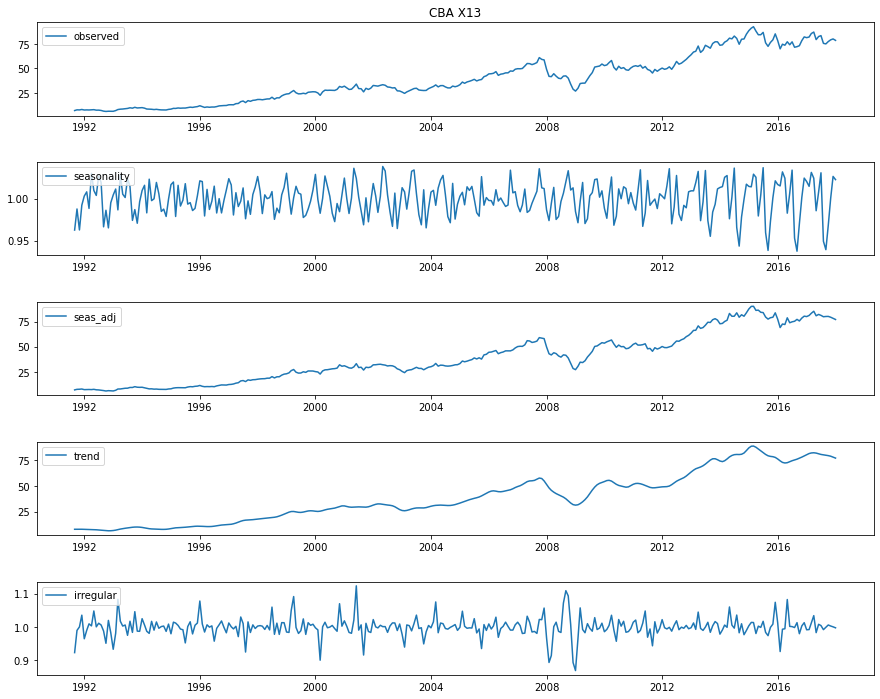

In [16]:
plt.figure()
fig, ax = plt.subplots(5, 1, figsize = (15,12))
ax[0].set_title( 'CBA X13')
ax[0].plot( model.observed )
ax[1].plot( model.observed / model.seasadj )
ax[2].plot( model.seasadj )
ax[3].plot( model.trend )
ax[4].plot( model.irregular )
ax[0].legend(['observed'], loc=2)
ax[1].legend(['seasonality'], loc=2)
ax[2].legend(['seas_adj'], loc=2)
ax[3].legend(['trend'], loc=2)
ax[4].legend(['irregular'], loc=2)
fig.subplots_adjust(hspace=0.5)

#plt.savefig('CBA-X13as.png')
